Prétraitement des données & formation sur les modèles

In [1]:
import numpy as np
import pandas as pd

X_train = pd.read_csv('../data_input/train.csv')
X_predict = pd.read_csv('../data_input/predict.csv')

1. Traitement les données en double

In [2]:
# Supprimer les lignes en double
X_train = X_train.drop_duplicates()

print(X_train.shape)

(58864, 129)


2. Resampling

In [3]:
from sklearn.utils import resample
from sklearn.utils import resample

# Séparation des catégories majoritaires et minoritaires

X_train_minority = X_train[(X_train.Response == 3) | (X_train.Response == 4)]
X_train_majority = X_train[(X_train.Response == 1) | (X_train.Response == 2) |
                           (X_train.Response == 5) | (X_train.Response == 6) |
                           (X_train.Response == 7) | (X_train.Response == 8)]

print(X_train.Response.value_counts())

# Suréchantillonnage des catégories minoritaires
X_train_minority_upsampled = resample(X_train_minority, replace=True,
                                      n_samples=12000,
                                      random_state=42)

# Fusionner la plupart des catégories et quelques catégories suréchantillonnées
X_train_upsampled = pd.concat([X_train_majority, X_train_minority_upsampled])

# Afficher le nouveau numéro de catégorie
print(X_train_upsampled.Response.value_counts())

X_train = X_train_upsampled

8    19318
6    11134
7     7944
2     6494
1     6157
5     5389
4     1419
3     1009
Name: Response, dtype: int64
8    19318
6    11134
7     7944
4     7062
2     6494
1     6157
5     5389
3     4938
Name: Response, dtype: int64


3. combiner train et predict

In [4]:
all_data = X_train.append(X_predict,sort=False)

all_data['Response'].fillna(-1, inplace=True)

# corrige le dtype sur la colonne label
all_data['Response'] = all_data['Response'].astype(int)

4. Traitement de la valeur manquante

In [5]:
def description(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    # Comptez le nombre de valeurs manquantes dans chaque colonne
    summary['Missing'] = df.isnull().sum().values    
    # Comptez le nombre de valeurs différentes dans chaque colonne, à l'exclusion des valeurs nulles
    summary['Uniques'] = df.nunique().values
    return summary

In [6]:
des_all_data = description(all_data)
des_all_data['Missing'] = des_all_data['Missing']/all_data.shape[0]
print(des_all_data[des_all_data['Missing']!=0].sort_values(by=['Missing'],ascending=False)[['Name','Missing']])

# si le taux manquant > 50%, nous supprimons cette caractère
cols = des_all_data[des_all_data['Missing'] >= 0.5]['Name']
print(cols)

all_data = all_data.drop(cols, axis=1)

# pour l'autre caractères manquante, nous remplaçons NaN par la valeur de Moyenne / Median
cols = des_all_data[des_all_data['Missing'] < 0.5]['Name']

# all_data[cols] = all_data[cols].fillna(all_data[cols].mean())

all_data[cols] = all_data[cols].fillna(all_data[cols].median())

print(all_data.isnull().sum().values)

                   Name   Missing
48   Medical_History_10  0.991006
70   Medical_History_32  0.976224
62   Medical_History_24  0.934417
24        InsuredInfo_8  0.881006
25        InsuredInfo_9  0.747911
38        Family_Hist_5  0.712356
53   Medical_History_15  0.661759
36        Family_Hist_3  0.587269
35        Family_Hist_2  0.472960
30  Insurance_History_5  0.441482
37        Family_Hist_4  0.315423
16    Employment_Info_6  0.189901
39    Medical_History_1  0.160381
14    Employment_Info_4  0.111872
11    Employment_Info_1  0.000276
24         InsuredInfo_8
25         InsuredInfo_9
36         Family_Hist_3
38         Family_Hist_5
48    Medical_History_10
53    Medical_History_15
62    Medical_History_24
70    Medical_History_32
Name: Name, dtype: object
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 

In [7]:
print(all_data.shape)

(68936, 121)


5. create new variables

In [8]:
all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]
all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']
med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

6. Standardization des données

In [9]:
# variables_discrete = ['Medical_History_1', 'Medical_History_10', 'Medical_History_15',
#                       'Medical_History_24', 'Medical_History_32']

# Seule cette variable est laissée 'Medical_History_1'

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
mh1_scale_param = ss.fit(all_data['Medical_History_1'].values.reshape(-1, 1))
all_data['Medical_History_1'] = ss.fit_transform(all_data['Medical_History_1'].values.reshape(-1, 1), mh1_scale_param)


7. Numérisation des données

In [10]:
all_data.info()

des_all_data = description(all_data)
print(des_all_data[des_all_data['dtypes']=='object'])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 68936 entries, 0 to 499
Columns: 125 entries, Product_Info_1 to Med_Keywords_Count
dtypes: float64(13), int64(108), object(4)
memory usage: 66.3+ MB
                    Name  dtypes  Missing  Uniques
1         Product_Info_2  object        0       19
23         InsuredInfo_7  object        0        2
121  Product_Info_2_char  object        0        5
122   Product_Info_2_num  object        0        8


In [11]:
# Numérisation des caractères : one-hot code

from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
all_data['Product_Info_2'] = label_encode.fit_transform(all_data['Product_Info_2'])
all_data['InsuredInfo_7'] = label_encode.fit_transform(all_data['InsuredInfo_7'])
all_data['Product_Info_2_char'] = label_encode.fit_transform(all_data['Product_Info_2_char'])
all_data['Product_Info_2_num'] = label_encode.fit_transform(all_data['Product_Info_2_num'])


8. PCA dimensionality reduction

In [12]:
# from sklearn.decomposition import PCA

# pca_all_data = all_data
# y_pca = pca_all_data['Response']
# del pca_all_data['Response']

# estimator = PCA(n_components='mle')
# pca_all_data = estimator.fit_transform(pca_all_data)

# print(estimator.n_components_)

# print(estimator.explained_variance_ratio_)

# pca_all_data = np.insert(pca_all_data, 125, values=y_pca, axis=1)

# all_data = pd.DataFrame(pca_all_data).rename(columns={125: 'Response'})

9. Sélection des caractères

In [13]:
from sklearn import feature_selection

# si le variance < 0.005 , nous supprimons cette caractère
sele = feature_selection.VarianceThreshold(threshold=0.005)

fs_all_data = all_data
y_pca = fs_all_data['Response']
del fs_all_data['Response']

fs_all_data = sele.fit_transform(fs_all_data)

fs_all_data = np.insert(fs_all_data, 121, values=y_pca, axis=1)

all_data = pd.DataFrame(fs_all_data).rename(columns={121: 'Response'})

10. Partitionnement de l'ensemble de données

In [14]:
all_data = pd.DataFrame(all_data)

# split train and test
train = all_data[all_data['Response'] > 0].copy()
predict = all_data[all_data['Response'] < 0].copy()

digits_data = train
digits_target = train['Response']
del digits_data['Response']

# Split data set
# Parce que le type de distribution label n'est pas uniforme,
# j'ai utilisé l'échantillonnage stratifié


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(digits_data, digits_target, test_size=0.25,
                                                    random_state=42, stratify=digits_target)

11. Formation de modèle

In [15]:
from sklearn.metrics import classification_report

results = pd.Series([])

LinearSVC

In [16]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC()
lsvc.fit(X_train,y_train)

y_predict = lsvc.predict(X_test)

# from sklearn.model_selection import cross_val_score

# print("Average prediction score: "+str(cross_val_score(lsvc, X_train, y_train, cv=5).mean()))

print(classification_report(y_test,y_predict))

print("precision in train set: "+str(lsvc.score(X_train, y_train)))
print("precision in test set: "+str(lsvc.score(X_test, y_test)))

results['LSVC'] = lsvc.score(X_test, y_test)

              precision    recall  f1-score   support

         1.0       0.49      0.06      0.10      1539
         2.0       0.44      0.00      0.01      1624
         3.0       0.80      0.00      0.01      1234
         4.0       0.56      0.01      0.01      1766
         5.0       0.00      0.00      0.00      1347
         6.0       0.33      0.00      0.00      2784
         7.0       0.13      0.47      0.20      1986
         8.0       0.43      0.85      0.57      4829

    accuracy                           0.30     17109
   macro avg       0.40      0.17      0.11     17109
weighted avg       0.39      0.30      0.20     17109

precision in train set: 0.30481033374247474
precision in test set: 0.3014203051025776


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomForest

In [17]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_predict = rfc.predict(X_test)

print(classification_report(y_test, y_predict))

print("precision in train set: "+str(rfc.score(X_train, y_train)))
print("precision in test set: "+str(rfc.score(X_test, y_test)))

results['RF'] = rfc.score(X_test, y_test)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

         1.0       0.28      0.24      0.26      1539
         2.0       0.29      0.22      0.25      1624
         3.0       0.89      0.97      0.93      1234
         4.0       0.84      0.97      0.90      1766
         5.0       0.48      0.40      0.44      1347
         6.0       0.38      0.38      0.38      2784
         7.0       0.37      0.26      0.30      1986
         8.0       0.66      0.81      0.72      4829

    accuracy                           0.56     17109
   macro avg       0.52      0.53      0.52     17109
weighted avg       0.53      0.56      0.54     17109

precision in train set: 0.9923042453289691
precision in test set: 0.5624525103746566


GBDT

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_predict = gbc.predict(X_test)

print(classification_report(y_test, y_predict))
print("precision in train set: "+str(gbc.score(X_train, y_train)))
print("precision in test set: "+str(gbc.score(X_test, y_test)))

results['GBDT'] = gbc.score(X_test, y_test)

              precision    recall  f1-score   support

         1.0       0.46      0.21      0.29      1539
         2.0       0.47      0.25      0.33      1624
         3.0       0.59      0.42      0.49      1234
         4.0       0.47      0.66      0.55      1766
         5.0       0.56      0.47      0.51      1347
         6.0       0.37      0.42      0.40      2784
         7.0       0.44      0.35      0.39      1986
         8.0       0.65      0.84      0.73      4829

    accuracy                           0.53     17109
   macro avg       0.50      0.45      0.46     17109
weighted avg       0.52      0.53      0.51     17109

precision in train set: 0.5500418882849183
precision in test set: 0.5263311707288562


LogisticRegression

In [19]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

print(classification_report(y_test, y_predict))
print("precision in train set: "+str(lr.score(X_train, y_train)))
print("precision in test set: "+str(lr.score(X_test, y_test)))

results['LR'] = lr.score(X_test, y_test)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

         1.0       0.39      0.24      0.30      1539
         2.0       0.35      0.20      0.26      1624
         3.0       0.40      0.35      0.37      1234
         4.0       0.41      0.60      0.49      1766
         5.0       0.40      0.22      0.28      1347
         6.0       0.31      0.28      0.30      2784
         7.0       0.38      0.24      0.29      1986
         8.0       0.58      0.85      0.69      4829

    accuracy                           0.46     17109
   macro avg       0.40      0.37      0.37     17109
weighted avg       0.43      0.46      0.43     17109

precision in train set: 0.4701813860151577
precision in test set: 0.457712315155766


SGDClassifier

In [20]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier()
sgdc.fit(X_train, y_train)
y_predict = sgdc.predict(X_test)

print(classification_report(y_test, y_predict))
print("precision in train set: "+str(sgdc.score(X_train, y_train)))
print("precision in test set: "+str(sgdc.score(X_test, y_test)))

results['sgdc'] = sgdc.score(X_test, y_test)

              precision    recall  f1-score   support

         1.0       0.35      0.20      0.26      1539
         2.0       0.37      0.02      0.04      1624
         3.0       0.49      0.02      0.03      1234
         4.0       0.47      0.08      0.14      1766
         5.0       0.31      0.01      0.03      1347
         6.0       0.18      0.90      0.29      2784
         7.0       0.40      0.07      0.11      1986
         8.0       0.78      0.17      0.29      4829

    accuracy                           0.23     17109
   macro avg       0.42      0.18      0.15     17109
weighted avg       0.47      0.23      0.19     17109

precision in train set: 0.23385352738324858
precision in test set: 0.23490560523700976


DecisionTree

In [21]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_predict = tree.predict(X_test)

print(classification_report(y_test, y_predict))
print("precision in train set: "+str(tree.score(X_train, y_train)))
print("precision in test set: "+str(tree.score(X_test, y_test)))

results['DTree'] = tree.score(X_test, y_test)

              precision    recall  f1-score   support

         1.0       0.20      0.18      0.19      1539
         2.0       0.24      0.23      0.23      1624
         3.0       0.81      0.98      0.89      1234
         4.0       0.82      0.97      0.89      1766
         5.0       0.39      0.36      0.37      1347
         6.0       0.33      0.32      0.32      2784
         7.0       0.30      0.28      0.29      1986
         8.0       0.65      0.64      0.65      4829

    accuracy                           0.50     17109
   macro avg       0.47      0.50      0.48     17109
weighted avg       0.49      0.50      0.49     17109

precision in train set: 1.0
precision in test set: 0.50301011163715


KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=8)

knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)

print(classification_report(y_test, y_predict))
print("precision in train set: "+str(knn.score(X_train, y_train)))
print("precision in test set: "+str(knn.score(X_test, y_test)))

results['KNN'] = knn.score(X_test, y_test)

              precision    recall  f1-score   support

         1.0       0.24      0.15      0.19      1539
         2.0       0.22      0.12      0.15      1624
         3.0       0.44      0.73      0.55      1234
         4.0       0.43      0.77      0.55      1766
         5.0       0.16      0.08      0.10      1347
         6.0       0.25      0.18      0.21      2784
         7.0       0.19      0.09      0.13      1986
         8.0       0.45      0.60      0.51      4829

    accuracy                           0.37     17109
   macro avg       0.30      0.34      0.30     17109
weighted avg       0.32      0.37      0.33     17109

precision in train set: 0.5007695754671031
precision in test set: 0.37208486761353676


XGBoost

In [23]:
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)
y_predict = xgbc.predict(X_test)

print(classification_report(y_test, y_predict))
print("precision in train set: "+str(xgbc.score(X_train, y_train)))
print("precision in test set: "+str(xgbc.score(X_test, y_test)))

results['XGBC'] = xgbc.score(X_test, y_test)

              precision    recall  f1-score   support

         1.0       0.46      0.17      0.25      1539
         2.0       0.45      0.23      0.30      1624
         3.0       0.58      0.36      0.44      1234
         4.0       0.43      0.67      0.53      1766
         5.0       0.56      0.47      0.51      1347
         6.0       0.35      0.40      0.37      2784
         7.0       0.43      0.33      0.37      1986
         8.0       0.64      0.84      0.73      4829

    accuracy                           0.51     17109
   macro avg       0.49      0.43      0.44     17109
weighted avg       0.50      0.51      0.49     17109

precision in train set: 0.5261753073431138
precision in test set: 0.5098486176865977


12. Comparaison de modèles

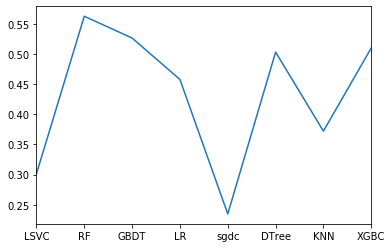

In [25]:
import matplotlib.pyplot as plt

results.plot()

plt.show()
